# Neural Network for Coupling prediction

## Data preprocessing

Importing the necessary libraries

In [1]:
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Importing datatset as Pandas dataframe and visualizing the first 5 rows

In [2]:
data = pd.read_csv("Datasets/COMPLETE_FULLDATA.csv",sep=";", decimal='.')
data.head()

,DIMERS,Xshift,Yshift,Zshift,alpha_deg,CPL [Ha],CPL [eV],CPL [meV],1st_exc_en,1st_exc_f,2nd_exc_en,2nd_exc_f,exc_split
0,ND3X0.0,-0.000358,-0.000230,3.0,0,0.006596,0.179485,179.484943,1.671243,0.000055,2.039965,0.712887,0.368723
1,ND3X0.2,-0.000358,0.539103,3.0,0,0.006328,0.172202,172.201816,1.689789,0.000402,2.040880,0.712912,0.351091
2,ND3X0.4,-0.000358,1.078436,3.0,0,0.005679,0.154526,154.525843,1.718518,0.000387,2.031394,0.708976,0.312876
3,ND3X0.6,-0.000358,1.617770,3.0,0,0.004892,0.133118,133.118374,1.769175,0.000005,2.034753,0.714190,0.265579
4,ND3X0.8,-0.000358,2.157103,3.0,0,0.004065,0.110612,110.612380,1.804709,0.000001,2.026748,0.710577,0.222039


Visualizing dataset dimensions

In [3]:
data.shape

(10560, 13)

In [4]:
data['alpha_deg'].unique()

array([  0,   5,  10,  15,  30,  45,  60,  70,  80,  90, 100, 110, 120,
       150, 180, 210, 240, 270, 300, 330], dtype=int64)

In [5]:
removed_angles = [90]
data_removed = data[~data['alpha_deg'].isin(removed_angles)]
data_angles = data[data['alpha_deg'].isin(removed_angles)]

In [6]:
data_angles

,DIMERS,Xshift,Yshift,Zshift,alpha_deg,CPL [Ha],CPL [eV],CPL [meV],1st_exc_en,1st_exc_f,2nd_exc_en,2nd_exc_f,exc_split
4752,ND3.0X90X0.0,0.250218,0.020419,3.000031,90,-4.360000e-05,-0.001186,-1.186416,1.814715,0.319665,1.844117,0.327656,0.029402
4753,ND3.0X90X0.2,0.250218,0.559752,3.000032,90,-8.110000e-05,-0.002207,-2.206843,1.824772,0.321306,1.842085,0.326835,0.017313
4754,ND3.0X90X0.4,0.250219,1.099085,3.000031,90,-1.288200e-04,-0.003505,-3.505371,1.845557,0.325504,1.858015,0.325324,0.012458
4755,ND3.0X90X0.6,0.250218,1.638419,3.000032,90,-1.769100e-04,-0.004814,-4.813966,1.860628,0.327560,1.881908,0.326616,0.021281
4756,ND3.0X90X0.8,0.250218,2.177752,3.000032,90,-2.257400e-04,-0.006143,-6.142698,1.870081,0.330197,1.897961,0.329861,0.027880
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,ND9.5X90X90d3.4,-8.919222,0.019920,9.498234,90,-3.100000e-07,-0.000008,-0.008436,1.900107,0.338501,1.900845,0.335147,0.000739
5276,ND9.5X90X90d3.6,-9.458556,0.019921,9.498128,90,-4.500000e-07,-0.000012,-0.012245,1.900251,0.338526,1.900991,0.335176,0.000740
5277,ND9.5X90X90d3.8,-9.997888,0.019920,9.498023,90,-5.900000e-07,-0.000016,-0.016055,1.900385,0.338549,1.901143,0.335207,0.000759
5278,ND9.5X90X90d4.0,-10.537222,0.019920,9.497917,90,-7.100000e-07,-0.000019,-0.019320,1.900505,0.338570,1.901303,0.335239,0.000798


Input features and output variable selection

In [7]:
X_train = data_removed[["Xshift","Yshift","Zshift","alpha_deg"]].values
y_train = data_removed["CPL [eV]"].values
X_test = data_angles[["Xshift","Yshift","Zshift","alpha_deg"]].values
y_test = data_angles["CPL [eV]"].values

In [8]:
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

Splitting of the data into train set and test set

Scaling of input features

In [9]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## Neural Network

Building of the Neural Network architecture

In [10]:
model = Sequential()
model.add(Dense(512, input_shape=(4,), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

Configuration of the model for training

In [11]:
model.compile(loss='mse', optimizer='adam')

A brief summary of the model

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2560      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 177,153
Trainable params: 177,153
Non-trai

Number of epochs used for training

In [13]:
num_epochs = 5000

In [14]:
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

Neural Network training

In [15]:
history = model.fit(X_train,y_train,epochs=num_epochs,validation_split = 0.1, shuffle=False, batch_size = X_train.shape[0], callbacks=[checkpoint_callback])

Epoch 1/5000
1/1 [==============================] - 3s 3s/step - loss: 0.0059 - val_loss: 0.0049
Epoch 2/5000
1/1 [==============================] - 1s 553ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 3/5000
1/1 [==============================] - 0s 310ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 4/5000
1/1 [==============================] - 0s 115ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/5000
1/1 [==============================] - 0s 108ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/5000
1/1 [==============================] - 0s 301ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/5000
1/1 [==============================] - 0s 370ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/5000
1/1 [==============================] - 0s 287ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/5000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/5000
1/1 [==============================] - 0s 406ms/step - loss: 0.0012 - val_loss: 0.0012
Ep

# Model Evaluation

In [16]:
model.load_weights("best_model.h5")

In [17]:
#Model testing
test_eval = model.evaluate(X_test, y_test)

17/17 [==============================] - 0s 3ms/step - loss: 5.9369e-05


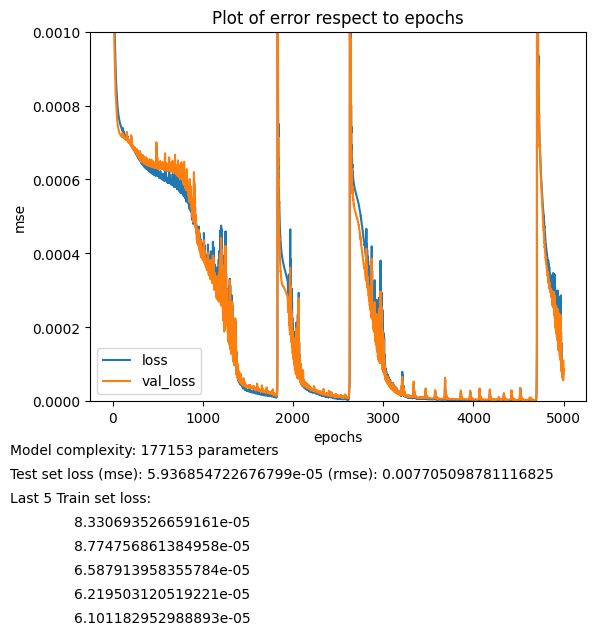

In [18]:
#plotting of training information
plt.plot(range(num_epochs),history.history['loss'])
plt.plot(range(num_epochs),history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.ylabel('mse')
plt.xlabel('epochs')
plt.title('Plot of error respect to epochs')
plt.ylim([0, 1e-3])
plt.figtext(0, 0, "Model complexity: "+str(model.count_params())+" parameters", fontsize=10)
plt.figtext(0, -0.05, "Test set loss (mse): "+str(test_eval)+" (rmse): "+str(math.sqrt(test_eval)), fontsize=10)
plt.figtext(0, -0.1, "Last 5 Train set loss:", fontsize=10)
plt.figtext(0.1, -0.15, str(history.history['loss'][-1]), fontsize=10)
plt.figtext(0.1, -0.2, str(history.history['loss'][-2]), fontsize=10)
plt.figtext(0.1, -0.25, str(history.history['loss'][-3]), fontsize=10)
plt.figtext(0.1, -0.3, str(history.history['loss'][-4]), fontsize=10)
plt.figtext(0.1, -0.35, str(history.history['loss'][-5]), fontsize=10)
plt.show()

# Empirical testing

In this part, model can be evaluated with empirical examples

In [19]:
#emp_test = np.array([-2.9219,3.009,4.4996,45])
#emp_test = np.reshape(emp_test,(1,4))
#emp_test = ss.transform(emp_test)

In [20]:
#model.predict(emp_test)

# Scatter plot

In [21]:
#Function that returns all the predictions of train set into a list
def predictions(X_test):
    pred = []

    for i in range(0,X_test.shape[0]):
        k = X_test[i]
        k = np.reshape(k,(1,4))
        #k = ss.transform(k)
        pred.append(float(model.predict(k))) 
    return pred

In [22]:
pred = predictions(X_test)

1/1 [==============================] - 0s 23ms/step


In [23]:
#mse test(to check if predictions are good)
mse = (y_test-pred)**2
np.sum(mse)/mse.shape[0]

5.9368478847967745e-05

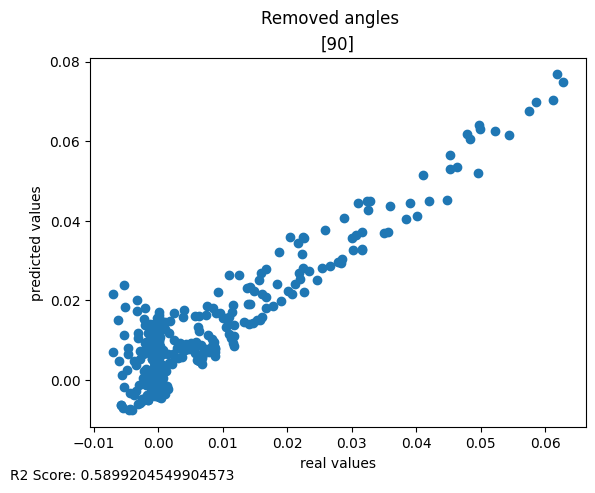

In [24]:
#scatter plot and r2 score
import sklearn
sklearn.metrics.r2_score(y_test,pred)

plt.scatter(y_test,pred)
plt.suptitle("Removed angles")
plt.title(removed_angles)
plt.ylabel('predicted values')
plt.xlabel('real values')
plt.figtext(0, 0, "R2 Score: "+str(sklearn.metrics.r2_score(y_test,pred)), fontsize=10)
plt.show()

# Saving model

In [25]:
#model.save('CPL_meV.h5')